In [97]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
import torch.random as random
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data import DataLoader

In [9]:
def f(a:tuple):
    return a[0] + a[1]

print(f((1, 2)))

3


(a) Write a PyTorch dataset which stores the training images

In [ ]:
class BrainImageDataset(Dataset):
    """
    A dataset for the brain images. The dataset is stored in a h5 file

    attributes:
    - self.h5pyfile: the h5 file object
    - self.brains: a list of all the brains in the dataset
    - self.global_values: a dictionary with the global mean and std of the dataset

    methods:
    - available_images(brain): returns a list of all the available images in a brain
    """

    def __init__(self, img_dir = './cell_data.h5', transform=None, \
        train=True, subset = False):
        self.transform = transform
        self.h5pyfile = h5py.File(img_dir, 'r')
        self.brains = list(self.h5pyfile.keys())

        # If we are training, we want to use all the brains except the last one
        if train:
            self.brains.pop(-1)
        else:
            self.brains = [self.brains[-1]]

        # calculate the global max, min, mean and std of the dataset
        self.global_values = self.global_mean_std()

    # Means and standard deviations for the dataset. See e01
    def global_mean_std(self):
        pixel_values = np.empty((0,5))
        for brain in self.brains:
            for image_name in self.h5pyfile[brain].keys():
                image = self.h5pyfile[brain][image_name][:].astype(np.float32)
                tuple = np.array([[image.size, image.min(), image.max(), image.mean(), (image**2).mean()]])
                pixel_values = np.append(pixel_values, tuple, axis=0)

        global_values = {}
        p = pixel_values[:,0]/np.sum(pixel_values[:,0])
        global_values['min'] = np.min(pixel_values[:,1])
        global_values['max'] = np.max(pixel_values[:,2])
        global_values['mean'] = p @ pixel_values[:,3]
        mean_squared= p @ pixel_values[:,4]
        global_values['std'] = np.sqrt(mean_squared - global_values['mean']**2)
        return global_values


    # Returns a list of all the available images in a brain
    def available_images(self, brain):
        return list(self.h5pyfile[brain].keys())

    def __getitem__(self, input: tuple):
        brain, image_name, row, column, tile_size = input
        # make sure the brain and image are in the dataset
        assert brain in self.brains, f'Brain {brain} not in dataset'
        assert image_name in self.available_images(brain), f'Image {image_name} not in brain {brain}'

        # make sure the tile is in the image
        image = self.h5pyfile[brain][image_name]
        assert row >= 0 and \
            row + tile_size <= image.shape[0], \
            f'Tile row {row} out of bounds'
        assert column >=0 and \
            column + tile_size <= image.shape[1], \
            f'Tile column {column} out of bounds'

        # get the tile
        tile = image[row:row+tile_size, column:column+tile_size]
        # to tensor
        tile = T.ToTensor()(tile)
        # standardize
        tile = T.Normalize(mean=self.global_values['mean'], \
                           std=self.global_values['std'])(tile)
        return tile


test_set = BrainImageDataset(train=True)

(b)Write a PyTorch Sampler to sample random training tile locations

In [130]:
class BrainRandomSampler(Sampler):
    def __init__(self, dataset, tile_size, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.tile_size = tile_size

        # save a probability distribution for each brain
        self.calculate_probabilities()

    # for each tile we sample 2 times, one for the brain and one for the image
    def calculate_probabilities(self):
        # the probability of each brain is the number of available images for the brain/total number of images
        self.brain_probabilities = np.array(
            [len(self.dataset.available_images(brain)) for brain in self.dataset.brains]
        )
        self.brain_probabilities = self.brain_probabilities/np.sum(self.brain_probabilities)

        # the probability of each image is the number of available tiles for the image/total number of tiles in the brain
        self.image_probabilites = {}
        for brain in self.dataset.brains:
            image_tiles = np.zeros(len(self.dataset.available_images(brain)))
            for image in self.dataset.available_images(brain):
                image_size = self.dataset.h5pyfile[brain][image].shape
                image_tiles = (image_size[0]-self.tile_size)*(image_size[1]-self.tile_size)
            self.image_probabilites[brain] = image_tiles/np.sum(image_tiles)

    def sample_tile(self):
            # sample the tuple based on the total number available tiles in each
            # brain and image
            brain = torch.randint(len(self.dataset.brains), (1, ))
            brain = self.dataset.brains[brain]
            image_name = torch.randint(len(self.dataset.available_images(brain)), (1,))
            image_name = self.dataset.available_images(brain)[image_name]

            # get the image
            image = self.dataset.h5pyfile[brain][image_name]
            # sample the row and column
            row = torch.randint(image.shape[0]-self.tile_size, (1,))
            column = torch.randint(image.shape[1]-self.tile_size, (1,))
            tile = (brain, image_name, int(row), int(column), self.tile_size)
            return tile

    def __iter__(self):
        # return a batch of samples using sample_tile for each sample
        batch = []
        for i in range(self.batch_size):
            batch.append(self.sample_tile())

        if len(batch) == self.batch_size:
            yield batch
            batch = []
    def __len__(self):
        return self.batch_size


# Note: Theoretically the sampler might choose the same tile multiple times
test_sampler = BrainRandomSampler(test_set, tile_size=45, batch_size=3)
next(iter(test_sampler))

[('B05', '0131', 406, 203, 45),
 ('B02', '0286', 531, 573, 45),
 ('B07', '0029', 56, 366, 45)]

(c) Create a PyTorch DataLoader object that takes the Dataset and Sampler as input

In [131]:
batch_size = 8
tile_size = 64

training_data = BrainImageDataset(train=True)
test_data = BrainImageDataset(train=False)

training_sampler = BrainRandomSampler(training_data, tile_size, batch_size)
test_sampler = BrainRandomSampler(test_data, tile_size, batch_size)

train_loader = DataLoader(training_data, batch_sampler=training_sampler)
test_loader = DataLoader(test_data, batch_sampler=test_sampler)

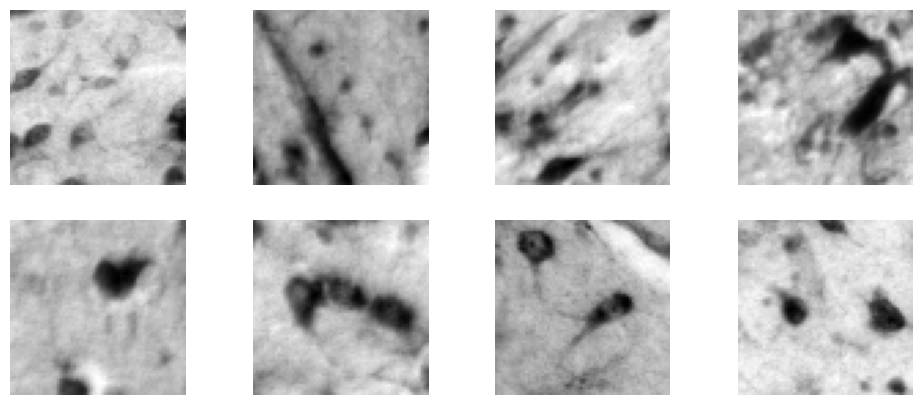

In [171]:
# a function to unnormalize the tensor
def unnormalize(tensor, mean, std):
    transform = T.Normalize(mean=[0], std=[1/std])
    tensor = transform(tensor)
    transform = T.Normalize(mean=[-mean], std=[1])
    tensor = transform(tensor)
    return tensor

# plot a single batch of images
mean, std = training_data.global_values['mean'], training_data.global_values['std']

fig, ax = plt.subplots((batch_size//4), 4, figsize=(12, 5))
i=0
for image in next(iter(train_loader)):
    image = unnormalize(image, mean, std)
    ax[i//4, i%4].imshow(image.squeeze(), cmap='gray')
    ax[i//4, i%4].axis('off')
    i+=1